In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
from utils import preprocess, missing, evaluate

In [4]:
input_dir = '.\\..\\data\\'

data_input = "cleaned_data.pkl"
data = pd.read_pickle(input_dir + data_input)

### Global Variables for the Linear Regression Forecast 

In [2]:
target = 'SI.POV.DDAY'
predict_year=2010

### Multicountry plot across all 9 independent variables and the dependent variable (SI.POV.DDAY)

The following plot is a quick illustration of the state of data in across multiple coutries.

One thing that it clearly shows is that there is a strong correlation of location of missing values for many of the variables. However for some others, such as SI.POV.DDAY and SI.POV.GINI this is less the case. 

Secondly, it is clear that we will need a model that is robust to missing values.

A key question here is if these patterns help us know if we have to model each country seperately or if one model fits all. Is there a method that can help us to work this out? Maybe there is a middle ground of number of models (for example a different model for every continent.

There are a number of outlier countries that could be investigated as well. For example, in SE.PRM.UNER. What should be done with these? How should our respond to these outliers?

In [141]:
#Create a list of coutries to be plotted in the summary plot below
regions = list(data.index.levels[0])[:50]

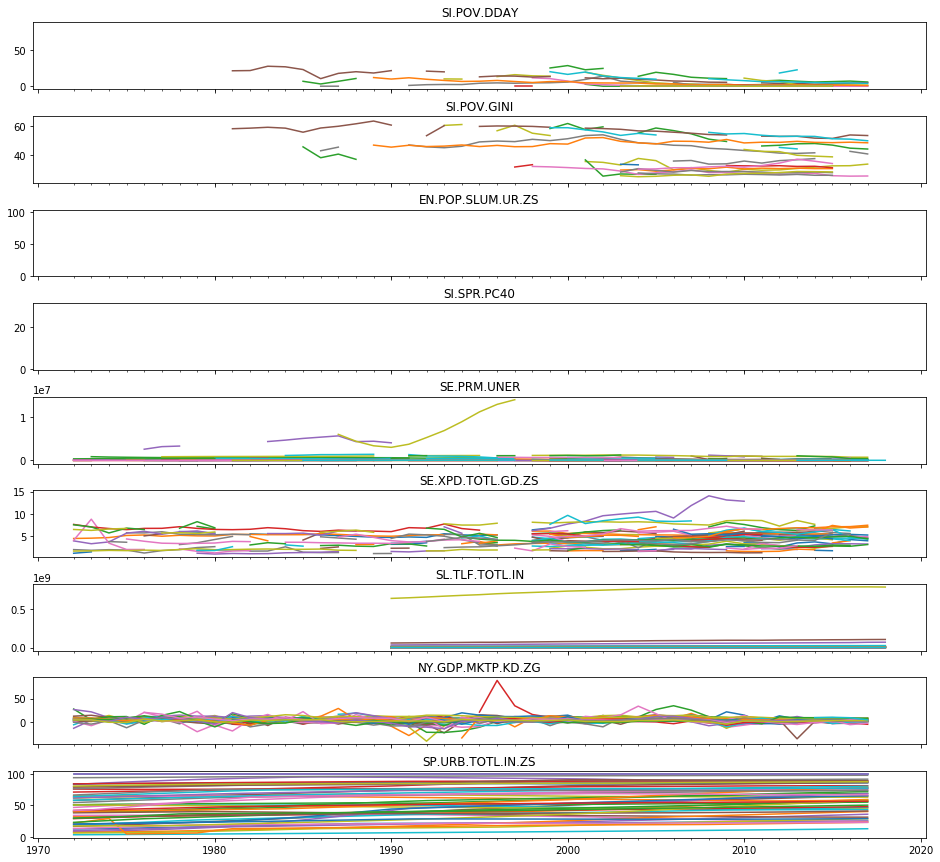

In [6]:
#pyplot.figure(figsize=(16, 20))
inputs = list(data.columns)

fig, axes = plt.subplots(len(inputs), 1, sharex=True ,figsize=(16, 15))

for i in range(len(inputs)):
    axes[i].set_xticks(list(range(1972,2018)), minor=True)
    axes[i].set_title(inputs[i])
    #ax.set_yticklabels([])
    column = inputs[i]
    for country in regions:
        values = data.loc[country][column].values
        axes[i].plot( list(range(1972,2019)), values)
plt.subplots_adjust(wspace=0, hspace=0.4)
#fig.invert_xaxis()
#pyplot.show()

### Missing Data Imputation

This represents a very first stab at imputation without any significance given to why the data is missing. Motivation right now is to get something working.

Approch is to do forward fill followed by back fill. Any remaining missing values are imputed with 0. 

In [9]:
#Investigate total missing values (%)
(data.isna().sum()/data.shape[0]) * 100

SI.POV.DDAY          84.658455
SI.POV.GINI          84.736842
EN.POP.SLUM.UR.ZS    95.520717
SI.SPR.PC40          98.051512
SE.PRM.UNER          59.518477
SE.XPD.TOTL.GD.ZS    63.617021
SL.TLF.TOTL.IN       46.853303
NY.GDP.MKTP.KD.ZG    20.929451
SP.URB.TOTL.IN.ZS     3.113102
dtype: float64

In [5]:
#get rid of EN.POP.SLUM.UR.ZS and SI.SPR.PC40 since they have so many missing values
#This needs to be removed from both the train and test regressors file
remove = ['EN.POP.SLUM.UR.ZS', 'SI.SPR.PC40']
data = data.drop(remove, axis=1)

#Missing value imputation using forward fill folled by backfill 
missing.perform_ffill_bfill(data, predict_year, target)
    
#Set remaining missing values to 0. (This should be replaced by mean imputation ASAP)

#First, for all columns except the target 
all_cols_except_target = list(data.columns.values)
all_cols_except_target.remove(target)

data.loc[:,all_cols_except_target] = data.loc[:,all_cols_except_target].fillna(0)
#Then, for the target just cover years up to the year before our target year.  
idx = pd.IndexSlice
data.loc[idx[:, :str(predict_year-1)], target] = data.loc[idx[:, :str(predict_year-1)], target].fillna(0)

### Break data into windows

Break up input dataframe (countries/year as 2-level index and economic indicators as columns) into windowed dataframes for training and testing.

A windowed data frame can be seen below. Each window row is a sliding window (of size 'lag') of the indictor data.

*Possible improvement: Refactor and create interface to wondowed data that allows us to return only teh data we need for specific purpose. Initialise with input dataframe and stores the windowed data. Can include imputation method as well. The windowing algo will need speed optimisation to scale so whould look at this well to see if it makes sence.*

In [6]:
data_train_regressors, data_train_targets, data_test_regressors, data_test_targets =   preprocess.window_data2(data, lag=5,num_windows=3, step=1, predict_year=2010, target=target)

#### Example windowed data frame

In [36]:
data_train_regressors.head(10)

SI.POV.DDAY                     SI.POV.GINI            \
lag                             1    2    3    4    5           1    2    3   
country        window                                                         
Afghanistan    1              0.0  0.0  0.0  0.0  0.0         0.0  0.0  0.0   
               2              0.0  0.0  0.0  0.0  0.0         0.0  0.0  0.0   
               3              0.0  0.0  0.0  0.0  0.0         0.0  0.0  0.0   
Albania        1              0.4  1.1  1.1  1.1  2.0         0.0  0.0  0.0   
               2              1.1  1.1  1.1  2.0  2.0         0.0  0.0  0.0   
               3              1.1  1.1  2.0  2.0  2.0         0.0  0.0  0.0   
Algeria        1              5.8  5.8  5.8  5.8  5.8         0.0  0.0  0.0   
               2              5.8  5.8  5.8  5.8  5.8         0.0  0.0  0.0   
               3              5.8  5.8  5.8  5.8  5.8         0.0  0.0  0.0   
American Samoa 1              0.0  0.0  0.0  0.0  0.0         0.0  0.0  0.0   

                                 ... NY.GDP.MKTP.KD.ZG                      \
lag                      4    5  ...                 1    2    3    4    5   
country        window            ...                                         
Afghanistan    1       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               2       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               3       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
Albania        1       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               2       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               3       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
Algeria        1       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               2       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
               3       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   
American Samoa 1       0.0  0.0  ...               0.0  0.0  0.0  0.0  0.0   

                      SP.URB.TOTL.IN.ZS                      
lag                                   1    2    3    4    5  
country        window                                        
Afghanistan    1                    0.0  0.0  0.0  0.0  0.0  
               2                    0.0  0.0  0.0  0.0  0.0  
               3                    0.0  0.0  0.0  0.0  0.0  
Albania        1                    0.0  0.0  0.0  0.0  0.0  
               2                    0.0  0.0  0.0  0.0  0.0  
               3                    0.0  0.0  0.0  0.0  0.0  
Algeria        1                    0.0  0.0  0.0  0.0  0.0  
               2                    0.0  0.0  0.0  0.0  0.0  
               3                    0.0  0.0  0.0  0.0  0.0  
American Samoa 1                    0.0  0.0  0.0  0.0  0.0  

[10 rows x 35 columns]

### Postprocess windows

Here we deal with windows that do not have any target value. Note that in the wondowed-data dataframe, every row is a window. Each windows will act as an observation in the input to our machine learning algorithm.

In the case of the training data we get rid of these windows (both in the regressor training dataframe and the target training dataframe. Without a target they don't tell us anything in the training process.

*TODO: Investigate possibility of imputing missing target data. One lead is [here](https://www.analyticbridge.datasciencecentral.com/forum/topics/missing-values-in-target)*

In the case of the test data, we also do the same as without a target, it is impossible to evaluate the error in prediction.


In [7]:
#For Training, only consider windows that don't have a missing target as they offer nothing to training
#Therefore, remove those observations from both the training regressors and targets datasets.
data_train_regressors_subset = data_train_regressors[~np.isnan(list(data_train_targets.values.flatten()))]
data_train_targets_subset = data_train_targets[~np.isnan(list(data_train_targets.values.flatten()))]

#For testing, also remove windows with no target variable as it is impossible to measure preformance.
data_test_regressors_subset = data_test_regressors[~np.isnan(list(data_test_targets.values.flatten()))]
data_test_targets_subset = data_test_targets[~np.isnan(list(data_test_targets.values.flatten()))]


### Linear Regression Prediction 

In [8]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
model_linear.fit(data_train_regressors_subset,data_train_targets_subset)
#Make predictions
predictions = model_linear.predict(data_test_regressors_subset)

In [9]:
#Refactor predictions to faciliate comparison later with the True values

#Convert to dataframe with coutry names as index
predictions_df = pd.DataFrame(predictions.flatten(), index=data_test_regressors_subset.index, columns=['SI.POV.DDAY'])
#Reindex in order to put back in the coutries that were removed due to lack of target.
predictions_df = predictions_df.reindex(data_test_targets.index)

#### Evaluate Performance

In [10]:
#forcing to ignore these 2 countries as they were not preidcted by the naive predictor and we want to compare
#the performance
ignore = ['Vanuatu','Tuvalu']
mse_result,no_true_value,countries_not_predicted = evaluate.mse_countries(data_test_targets, predictions_df, ignore)

print("MSE of Linear Regression is:", mse_result)

MSE of Linear Regression is: 18.84457297461422


In [24]:
countries_not_predicted

{'Tuvalu', 'Vanuatu'}

#### Most poorly predicted countries

In [41]:
((predictions_df - data_test_targets)**2).sort_values(by='SI.POV.DDAY',ascending=False).head(10)

,SI.POV.DDAY
Nepal,927.615
Guinea-Bissau,193.898
Vanuatu,175.869
Vietnam,98.3111
Madagascar,54.9648
Bangladesh,32.148
Rwanda,26.2639
Zambia,20.8147
Pakistan,18.9102
Tuvalu,11.9824
